In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

# Import data

In [2]:
%store -r dataset
dataset

,Body,Tags
0,<p>I have a UIImageView that I have already se...,[iphone]
2,<h2>The requirements I'm up against</h2>\n\n<p...,"[c#, winforms]"
4,<p>I am using the xml-simple gem inside a rake...,"[ruby, xml]"
5,<p>I'm trying to get a PHP array that includes...,[php]
7,<p>I have done some Google searching and found...,"[python, sql, django]"
...,...,...
99706,<p>So I'm trying to get rid of my std::vector'...,[c++]
99707,<p>Is it possible to have a singleton in a fac...,[java]
99708,<p>I was wondering if there is some option to ...,"[c#, visual-studio-2008]"
99709,"<p>I have found the ""Getting Started"" document...",[iphone]


# Fonctions utilitaires

In [3]:
class Opts:
    def __init__(self, print_cm, print_report, feature_names, target_names = None):
        self.print_cm = print_cm
        self.print_report = print_report
        self.target_names = target_names
        self.feature_names = feature_names
    
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

def benchmark(data, clf, clf_name, opts):
    (X_train, X_test, y_train, y_test) = data
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    f1_micro = metrics.f1_score(y_test, pred, average='micro')
    print("f1-score (micro):   %0.3f" % f1_micro)
    f1_macro = metrics.f1_score(y_test, pred, average='macro')
    print("f1-score (macro):   %0.3f" % f1_macro)

    coef = None
    if hasattr(clf, 'estimators_') and all(hasattr(estimator, 'coef_') for estimator in clf.estimators_):
        coef = np.concatenate([estimator.coef_ for estimator in clf.estimators_])
    elif hasattr(clf, 'coef_'):
        coef = clf.coef_
        
    if type(coef) != type(None):
        print("dimensionality: %d" % coef.shape[1])
        print("density: %f" % density(coef))

        if opts.target_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(opts.target_names):
                top10 = np.argsort(coef[i])[-10:]
                print("%s: %s" % (label, " ".join(opts.target_names[top10])))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=opts.target_names,
                                            zero_division=0))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.multilabel_confusion_matrix(y_test, pred))

    print()
    return clf_name, score, f1_micro, f1_macro, train_time, test_time

In [4]:
def get_preprocessing_pipeline(select_chi2 = None):
    return Pipeline([
        ('tf-idf', TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')),
        ('feature-reduction', SelectKBest(chi2, k=select_chi2) if select_chi2 else 'passthrough')
    ])

In [5]:
def evaluate_models(X, y, select_chi2 = 500, print_cm = False, print_report = True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    mlb = MultiLabelBinarizer().fit(y.to_list())
    y_train = mlb.transform(y_train)
    y_test = mlb.transform(y_test)
    target_names = mlb.classes_

    preprocess_pipeline = get_preprocessing_pipeline(select_chi2)
    X_train = preprocess_pipeline.fit_transform(X_train, y_train)
    X_test = preprocess_pipeline.transform(X_test)
    
    data = (X_train, X_test, y_train, y_test)
    feature_names = preprocess_pipeline.named_steps['tf-idf'].get_feature_names()
    opts = Opts(print_cm, print_report, target_names)
 
    results = []
    for clf, name in (
            (RidgeClassifier(tol=1e-2, solver="sag", random_state=1), "Ridge Classifier"),
            (OneVsRestClassifier(Perceptron(max_iter=50, n_jobs=-1, random_state=2), n_jobs=-1), "Perceptron"),
            (OneVsRestClassifier(PassiveAggressiveClassifier(max_iter=50, n_jobs=-1, random_state=3)),
             "Passive-Aggressive"),
            (KNeighborsClassifier(n_neighbors=10, n_jobs=-1), "kNN"),
            (RandomForestClassifier(n_jobs=-1, random_state=5), "Random forest")):
        print('=' * 80)
        print(name)
        results.append(benchmark(data, clf, name, opts))

    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        results.append(benchmark(data, OneVsRestClassifier(LinearSVC(penalty=penalty, dual=False,
                                           tol=1e-3, random_state=5)), f'LinearSVC {penalty.upper()}', opts))

        # Train SGD model
        results.append(benchmark(data, OneVsRestClassifier(SGDClassifier(alpha=.0001, max_iter=50,
                                               penalty=penalty, n_jobs=-1, random_state=3)), 'SGD Classifier', opts))

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    name = "Elastic-Net penalty"
    print(name)
    results.append(benchmark(data, OneVsRestClassifier(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty="elasticnet", n_jobs=-1, random_state=5)), name, opts))

    # Train sparse Naive Bayes classifiers
    print('=' * 80)
    print("Naive Bayes")
    results.append(benchmark(data, OneVsRestClassifier(MultinomialNB(alpha=.01)), 'Mutltinomial NB', opts))
    results.append(benchmark(data, OneVsRestClassifier(BernoulliNB(alpha=.01)), 'Bernoulli NB', opts))
    results.append(benchmark(data, OneVsRestClassifier(ComplementNB(alpha=.1)), 'Complement NB', opts))

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(6)]

    clf_names, score, f1_micro, f1_macro, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(14, 8))
    plt.title("Score")
    plt.barh(indices, score, .1, label="score", color='navy')
    plt.barh(indices + .2, f1_micro, .1, label="F1 (micro)", color='b')
    plt.barh(indices + .4, f1_macro, .1, label="F1 (macro)", color='m')
    plt.barh(indices + .6, training_time, .1, label="training time",
             color='c')
    plt.barh(indices + .8, test_time, .1, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()

    result_df = pd.DataFrame(np.array(results[1:]).T, index=results[0], columns=['Score', 'F1 micro', 'F1 macro', 'Training time', 'Testing time'])
    display(result_df)

    print('Best score algorithm:')
    print(f'{result_df["Score"].idxmax()}: {result_df["Score"].max()}')
    print('_' * 80)
    print('Best f1 micro algorithm:')
    print(f'{result_df["F1 micro"].idxmax()}: {result_df["F1 micro"].max()}')
    print('_' * 80)
    print('Best f1 macro algorithm:')
    print(f'{result_df["F1 macro"].idxmax()}: {result_df["F1 macro"].max()}')
    print('_' * 80)
    print('Fastest training algorithm:')
    print(f'{result_df["Training time"].idxmin()}: {result_df["Training time"].min()}')
    print('_' * 80)
    print('Fastest testing algorithm:')
    print(f'{result_df["Testing time"].idxmin()}: {result_df["Testing time"].min()}')
    print('_' * 80)

# Évaluation des différents modèles

Nous allons tester différentes combinaisons de modèles compatible avec des matrices creuses pour une prédiction multilabels.
Les modèles seront ensuite évaluer sur leur F-score et leur temps d'entrainement et de prédiction.

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(random_state=1, solver='sag', tol=0.01)
train time: 2.447s
test time:  0.004s
accuracy:   0.255
f1-score (micro):   0.493
f1-score (micro):   0.455
dimensionality: 500
density: 1.000000

classification report:
              precision    recall  f1-score   support

           0       0.69      0.16      0.25      1362
           1       0.66      0.33      0.44       207
           2       0.78      0.24      0.37       175
           3       0.98      0.62      0.76       465
           4       0.65      0.21      0.31       217
           5       0.80      0.43      0.56       973
           6       0.84      0.56      0.67       257
           7       0.88      0.22      0.35       425
           8       0.58      0.14      0.22      2210
           9       0.84      0.30      0.44      1009
          10       0.79      0.51      0.62       430
          11    

test time:  20.373s
accuracy:   0.253
f1-score (micro):   0.448
f1-score (micro):   0.423
classification report:
              precision    recall  f1-score   support

           0       0.60      0.13      0.21      1362
           1       0.77      0.17      0.28       207
           2       0.69      0.34      0.45       175
           3       0.98      0.56      0.72       465
           4       0.65      0.18      0.28       217
           5       0.82      0.33      0.47       973
           6       0.92      0.41      0.57       257
           7       0.78      0.25      0.38       425
           8       0.54      0.19      0.28      2210
           9       0.83      0.32      0.46      1009
          10       0.85      0.40      0.54       430
          11       0.53      0.05      0.10       346
          12       0.97      0.49      0.65       177
          13       0.86      0.57      0.69       161
          14       0.84      0.52      0.64       147
          15       0.6

train time: 0.943s
test time:  0.009s
accuracy:   0.210
f1-score (micro):   0.405
f1-score (micro):   0.307
dimensionality: 500
density: 0.830400

classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1362
           1       0.00      0.00      0.00       207
           2       0.00      0.00      0.00       175
           3       0.97      0.61      0.75       465
           4       0.00      0.00      0.00       217
           5       0.78      0.40      0.53       973
           6       0.83      0.47      0.60       257
           7       0.91      0.10      0.17       425
           8       0.00      0.00      0.00      2210
           9       0.93      0.22      0.36      1009
          10       0.83      0.46      0.59       430
          11       0.00      0.00      0.00       346
          12       0.93      0.64      0.76       177
          13       0.80      0.65      0.72       161
          14       

train time: 1.627s
test time:  0.009s
accuracy:   0.214
f1-score (micro):   0.411
f1-score (micro):   0.312
dimensionality: 500
density: 0.175040

classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1362
           1       0.00      0.00      0.00       207
           2       0.00      0.00      0.00       175
           3       0.97      0.62      0.76       465
           4       0.00      0.00      0.00       217
           5       0.78      0.41      0.53       973
           6       0.82      0.47      0.60       257
           7       0.89      0.10      0.18       425
           8       1.00      0.00      0.00      2210
           9       0.92      0.22      0.36      1009
          10       0.81      0.48      0.60       430
          11       0.00      0.00      0.00       346
          12       0.93      0.66      0.77       177
          13       0.78      0.66      0.71       161
          14       

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 0.361s
test time:  0.096s
accuracy:   0.159
f1-score (micro):   0.495
f1-score (micro):   0.488
dimensionality: 500
density: 1.000000

classification report:
              precision    recall  f1-score   support

           0       0.33      0.49      0.39      1362
           1       0.14      0.59      0.23       207
           2       0.30      0.52      0.38       175
           3       0.84      0.74      0.78       465
           4       0.28      0.68      0.40       217
           5       0.54      0.66      0.59       973
           6       0.41      0.76      0.53       257
           7       0.31      0.55      0.39       425
           8       0.43      0.49      0.46      2210
           9       0.45      0.59      0.51      1009
          10       0.36      0.65      0.47       430
          11       0.16      0.54      0.25       346
          12       0.58      0.71      0.64       177
          13       0.46      0.80      0.58       161
          14       

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 0.292s
test time:  0.078s
accuracy:   0.007
f1-score (micro):   0.281
f1-score (micro):   0.270
dimensionality: 500
density: 1.000000

classification report:
              precision    recall  f1-score   support

           0       0.23      0.77      0.35      1362
           1       0.07      0.93      0.13       207
           2       0.06      0.79      0.11       175
           3       0.28      0.92      0.43       465
           4       0.08      0.93      0.16       217
           5       0.26      0.86      0.40       973
           6       0.12      0.90      0.21       257
           7       0.14      0.76      0.23       425
           8       0.33      0.79      0.47      2210
           9       0.26      0.77      0.39      1009
          10       0.23      0.93      0.37       430
          11       0.11      0.83      0.20       346
          12       0.16      0.89      0.28       177
          13       0.09      0.90      0.17       161
          14       

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


train time: 7.157s
test time:  0.010s
accuracy:   0.271
f1-score (micro):   0.511
f1-score (micro):   0.459
classification report:
              precision    recall  f1-score   support

           0       0.65      0.19      0.29      1362
           1       0.63      0.34      0.44       207
           2       0.65      0.21      0.32       175
           3       0.95      0.68      0.79       465
           4       0.61      0.19      0.29       217
           5       0.78      0.45      0.57       973
           6       0.82      0.55      0.66       257
           7       0.83      0.22      0.35       425
           8       0.58      0.16      0.25      2210
           9       0.85      0.35      0.49      1009
          10       0.75      0.42      0.54       430
          11       0.29      0.01      0.02       346
          12       0.93      0.63      0.75       177
          13       0.78      0.66      0.72       161
          14       0.85      0.56      0.68       147
    

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


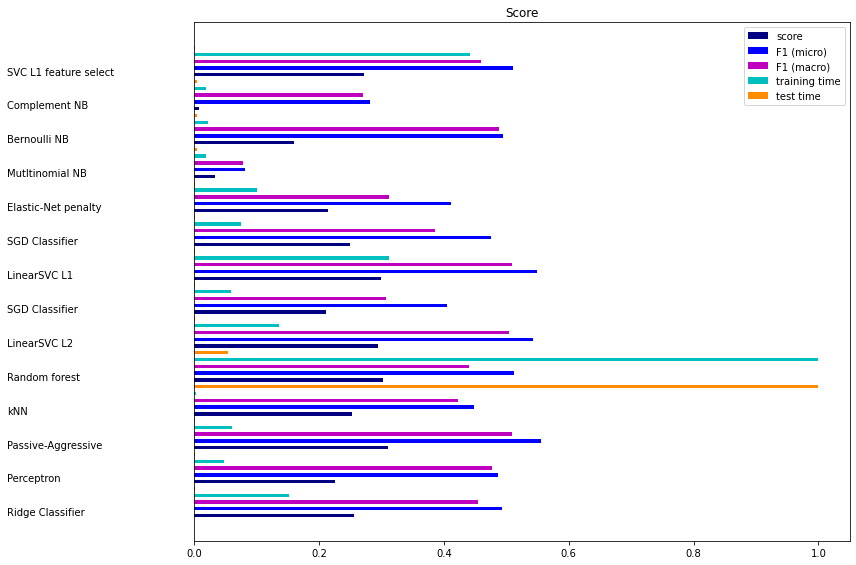

,Score,F1 micro,F1 macro,Training time,Testing time
Ridge Classifier,0.255216,0.492810,0.454668,2.447045,0.003553
Perceptron,0.225806,0.486681,0.476669,0.762712,0.011053
Passive-Aggressive,0.310194,0.556067,0.508745,0.983844,0.009657
kNN,0.253030,0.448408,0.422558,0.051243,20.372884
Random forest,0.302444,0.512391,0.440183,16.196765,1.100172
LinearSVC L2,0.295026,0.543017,0.504459,2.185166,0.009595
SGD Classifier,0.210373,0.404648,0.306601,0.942787,0.009204
LinearSVC L1,0.299199,0.548284,0.508541,5.049499,0.009871
SGD Classifier,0.249917,0.475472,0.385886,1.204906,0.009406
Elastic-Net penalty,0.214480,0.410725,0.312227,1.627044,0.009236


Best score algorithm:
Passive-Aggressive: 0.3101940782937007
________________________________________________________________________________
Best f1 micro algorithm:
Passive-Aggressive: 0.5560673213406333
________________________________________________________________________________
Best f1 macro algorithm:
Passive-Aggressive: 0.5087450961758788
________________________________________________________________________________
Fastest training algorithm:
kNN: 0.051242828369140625
________________________________________________________________________________
Fastest testing algorithm:
Ridge Classifier: 0.003552675247192383
________________________________________________________________________________


In [6]:
evaluate_models(dataset['Body'], dataset['Tags'])

Le modèle Passive-Aggressive sort en tête, suivi de près par le LinearSVC L1. Cependant, un tuning des hyperparamètres de ce dernier devrait pouvoir le faire passer au-dessus.

## Évaluation avec un input lemmatisé

Regardons l'impact d'un preprocessing permettant de ne récupérer que les lemmes de l'input.

In [7]:
import nltk
from nltk.stem import WordNetLemmatizer

tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+')
tokens = dataset['Body'].str.lower().map(tokenizer.tokenize)
tokens

0        [p, i, have, a, uiimageview, that, i, have, al...
2        [h, the, requirements, i, m, up, against, h, p...
4        [p, i, am, using, the, xml, simple, gem, insid...
5        [p, i, m, trying, to, get, a, php, array, that...
7        [p, i, have, done, some, google, searching, an...
                               ...                        
99706    [p, so, i, m, trying, to, get, rid, of, my, st...
99707    [p, is, it, possible, to, have, a, singleton, ...
99708    [p, i, was, wondering, if, there, is, some, op...
99709    [p, i, have, found, the, getting, started, doc...
99710    [p, i, have, a, d, area, with, dots, distribut...
Name: Body, Length: 75481, dtype: object

In [8]:
wnl = WordNetLemmatizer()
lem_tokens = tokens.map(lambda x: [wnl.lemmatize(w) for w in x])
lem_tokens

0        [p, i, have, a, uiimageview, that, i, have, al...
2        [h, the, requirement, i, m, up, against, h, p,...
4        [p, i, am, using, the, xml, simple, gem, insid...
5        [p, i, m, trying, to, get, a, php, array, that...
7        [p, i, have, done, some, google, searching, an...
                               ...                        
99706    [p, so, i, m, trying, to, get, rid, of, my, st...
99707    [p, is, it, possible, to, have, a, singleton, ...
99708    [p, i, wa, wondering, if, there, is, some, opt...
99709    [p, i, have, found, the, getting, started, doc...
99710    [p, i, have, a, d, area, with, dot, distribute...
Name: Body, Length: 75481, dtype: object

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(random_state=1, solver='sag', tol=0.01)
train time: 2.887s
test time:  0.003s
accuracy:   0.256
f1-score (micro):   0.489
f1-score (micro):   0.435
dimensionality: 500
density: 1.000000

classification report:
              precision    recall  f1-score   support

           0       0.69      0.15      0.25      1358
           1       0.62      0.38      0.47       196
           2       0.66      0.19      0.29       178
           3       0.97      0.57      0.72       507
           4       0.60      0.20      0.30       188
           5       0.78      0.39      0.52       928
           6       0.80      0.52      0.63       260
           7       0.77      0.21      0.33       412
           8       0.63      0.14      0.23      2185
           9       0.87      0.31      0.46       989
          10       0.76      0.54      0.63       417
          11    

test time:  21.194s
accuracy:   0.249
f1-score (micro):   0.444
f1-score (micro):   0.410
classification report:
              precision    recall  f1-score   support

           0       0.62      0.15      0.24      1358
           1       0.64      0.14      0.23       196
           2       0.72      0.33      0.45       178
           3       0.96      0.54      0.69       507
           4       0.52      0.21      0.30       188
           5       0.83      0.31      0.46       928
           6       0.88      0.41      0.56       260
           7       0.71      0.21      0.33       412
           8       0.57      0.22      0.32      2185
           9       0.84      0.31      0.45       989
          10       0.86      0.40      0.54       417
          11       0.53      0.06      0.11       296
          12       0.98      0.51      0.67       174
          13       0.84      0.49      0.62       154
          14       0.88      0.61      0.72       128
          15       0.6

train time: 0.992s
test time:  0.010s
accuracy:   0.215
f1-score (micro):   0.412
f1-score (micro):   0.309
dimensionality: 500
density: 0.834160

classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1358
           1       0.00      0.00      0.00       196
           2       0.00      0.00      0.00       178
           3       0.97      0.60      0.74       507
           4       0.00      0.00      0.00       188
           5       0.77      0.39      0.52       928
           6       0.81      0.46      0.59       260
           7       0.86      0.11      0.19       412
           8       0.00      0.00      0.00      2185
           9       0.95      0.23      0.37       989
          10       0.80      0.51      0.62       417
          11       0.00      0.00      0.00       296
          12       0.93      0.64      0.76       174
          13       0.74      0.69      0.71       154
          14       

train time: 1.854s
test time:  0.010s
accuracy:   0.216
f1-score (micro):   0.416
f1-score (micro):   0.314
dimensionality: 500
density: 0.193960

classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1358
           1       0.00      0.00      0.00       196
           2       0.00      0.00      0.00       178
           3       0.97      0.61      0.75       507
           4       0.00      0.00      0.00       188
           5       0.76      0.39      0.52       928
           6       0.78      0.47      0.58       260
           7       0.84      0.11      0.20       412
           8       0.50      0.00      0.00      2185
           9       0.94      0.23      0.37       989
          10       0.79      0.51      0.62       417
          11       0.00      0.00      0.00       296
          12       0.91      0.66      0.76       174
          13       0.73      0.70      0.72       154
          14       

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 0.364s
test time:  0.100s
accuracy:   0.154
f1-score (micro):   0.495
f1-score (micro):   0.483
dimensionality: 500
density: 1.000000

classification report:
              precision    recall  f1-score   support

           0       0.31      0.51      0.39      1358
           1       0.14      0.61      0.23       196
           2       0.37      0.56      0.44       178
           3       0.78      0.68      0.73       507
           4       0.23      0.69      0.34       188
           5       0.51      0.65      0.57       928
           6       0.39      0.71      0.51       260
           7       0.29      0.52      0.38       412
           8       0.44      0.53      0.48      2185
           9       0.48      0.60      0.53       989
          10       0.37      0.66      0.47       417
          11       0.14      0.56      0.23       296
          12       0.55      0.76      0.64       174
          13       0.41      0.83      0.55       154
          14       

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 0.299s
test time:  0.081s
accuracy:   0.008
f1-score (micro):   0.281
f1-score (micro):   0.268
dimensionality: 500
density: 1.000000

classification report:
              precision    recall  f1-score   support

           0       0.23      0.79      0.36      1358
           1       0.07      0.94      0.12       196
           2       0.06      0.84      0.11       178
           3       0.32      0.91      0.48       507
           4       0.07      0.94      0.14       188
           5       0.24      0.86      0.38       928
           6       0.13      0.89      0.22       260
           7       0.13      0.75      0.22       412
           8       0.33      0.81      0.47      2185
           9       0.27      0.80      0.41       989
          10       0.24      0.93      0.38       417
          11       0.10      0.85      0.17       296
          12       0.15      0.94      0.26       174
          13       0.08      0.93      0.15       154
          14       

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=OneVsRestClassifier(estimator=LinearSVC(dual=False,
                                                                                   penalty='l1',
                                                                                   random_state=4,
                                                                                   tol=0.001)))),
                ('classification',
                 OneVsRestClassifier(estimator=LinearSVC(random_state=8)))])


/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


train time: 8.054s
test time:  0.010s
accuracy:   0.273
f1-score (micro):   0.511
f1-score (micro):   0.447
classification report:
              precision    recall  f1-score   support

           0       0.68      0.18      0.28      1358
           1       0.63      0.38      0.48       196
           2       0.69      0.22      0.34       178
           3       0.96      0.65      0.77       507
           4       0.52      0.24      0.33       188
           5       0.76      0.43      0.55       928
           6       0.78      0.50      0.61       260
           7       0.72      0.18      0.29       412
           8       0.62      0.17      0.26      2185
           9       0.87      0.34      0.49       989
          10       0.73      0.46      0.56       417
          11       0.17      0.00      0.01       296
          12       0.92      0.72      0.81       174
          13       0.73      0.67      0.70       154
          14       0.80      0.54      0.64       128
    

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


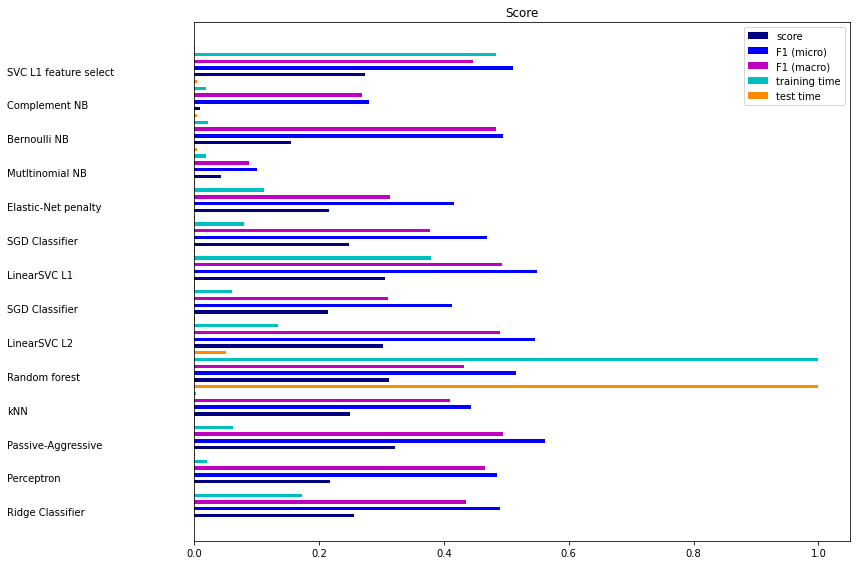

,Score,F1 micro,F1 macro,Training time,Testing time
Ridge Classifier,0.255614,0.489493,0.435096,2.887325,0.003275
Perceptron,0.216997,0.485502,0.465792,0.339291,0.024779
Passive-Aggressive,0.321057,0.561244,0.493981,1.034138,0.010176
kNN,0.249056,0.443992,0.409919,0.050888,21.194478
Random forest,0.311651,0.515086,0.431439,16.669483,1.061377
LinearSVC L2,0.302643,0.545035,0.490332,2.241432,0.010112
SGD Classifier,0.214745,0.412230,0.309460,0.991599,0.009709
LinearSVC L1,0.305359,0.548948,0.493242,6.318007,0.010235
SGD Classifier,0.247135,0.469633,0.378155,1.325039,0.009919
Elastic-Net penalty,0.216467,0.416107,0.313618,1.853612,0.009740


Best score algorithm:
Passive-Aggressive: 0.3210571636749023
________________________________________________________________________________
Best f1 micro algorithm:
Passive-Aggressive: 0.5612437277025264
________________________________________________________________________________
Best f1 macro algorithm:
Passive-Aggressive: 0.4939811439619441
________________________________________________________________________________
Fastest training algorithm:
kNN: 0.0508875846862793
________________________________________________________________________________
Fastest testing algorithm:
Ridge Classifier: 0.003274679183959961
________________________________________________________________________________


In [9]:
evaluate_models(lem_tokens.map(lambda x: ' '.join(x)), dataset['Tags'])

Les résultats sont quasi identiques avec cette étape supplémentaire. Nous laissons donc tomber la lemmatisation.

# Recherche des hyperparamètres

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset['Body'], dataset['Tags'], test_size=0.2)
mlb = MultiLabelBinarizer().fit(dataset['Tags'].to_list())
y_train = mlb.transform(y_train)
y_test = mlb.transform(y_test)
target_names = mlb.classes_
    

Pour peaufinner notre modèle, nous allons modifier plusieurs hyperparamètres :
* Le nombre de features sélectionnées par Chi2
* La création de n-gram par TF-IDF
* La tolérance de notre LinearSVC
* Le paramètre de régularisation C de LinearSVC

Comme nous avons déjà testé la pénalité L2 lors du benchmark, celle-ci ne sera pas testée.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
    
pipe = Pipeline([
    ('preprocessing', get_preprocessing_pipeline(500)),
    ('linearSVC', OneVsRestClassifier(LinearSVC(penalty='l1', dual=False,
                                           random_state=5, max_iter=5000), n_jobs=-1))
])

param_grid = {
    'linearSVC__estimator__C': np.linspace(98, 101, 4),
    'linearSVC__estimator__tol': np.logspace(-4, 0, 5),
    'preprocessing__feature-reduction__k': [500, 1000],
    'preprocessing__tf-idf__ngram_range': [(1,1), (1,2)]
}

grid_search = GridSearchCV(
    pipe, param_grid, cv=5, scoring=make_scorer(metrics.f1_score, average='macro'), error_score='raise', n_jobs=-1)

grid_search.fit(X_train, y_train)

grid_search.score(X_test, y_test)

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.1

0.575438565618446

In [6]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('tf-idf',
                                  TfidfVectorizer(max_df=0.5,
                                                  ngram_range=(1, 2),
                                                  stop_words='english',
                                                  sublinear_tf=True)),
                                 ('feature-reduction',
                                  SelectKBest(k=1000,
                                              score_func=<function chi2 at 0x7f2f96e7ce50>))])),
                ('linearSVC',
                 OneVsRestClassifier(estimator=LinearSVC(C=98.0, dual=False,
                                                         max_iter=5000,
                                                         penalty='l1',
                                                         random_state=5,
                                                         tol=0.01),
                                     n_jobs=-1))])

In [8]:
data = (X_train, X_test, y_train, y_test)
model = grid_search.best_estimator_
feature_names = model.named_steps['preprocessing'].named_steps['tf-idf'].get_feature_names_out()
opts = Opts(True, True, feature_names, target_names)
benchmark(data, model, 'LinearSVC L1', opts)

________________________________________________________________________________
Training: 
Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('tf-idf',
                                  TfidfVectorizer(max_df=0.5,
                                                  ngram_range=(1, 2),
                                                  stop_words='english',
                                                  sublinear_tf=True)),
                                 ('feature-reduction',
                                  SelectKBest(k=1000,
                                              score_func=<function chi2 at 0x7f2a50e2cee0>))])),
                ('linearSVC',
                 OneVsRestClassifier(estimator=LinearSVC(C=99.0, dual=False,
                                                         max_iter=5000,
                                                         penalty='l1',
                                                         random_state=5,
                          

('LinearSVC L1',
 0.3358283102603166,
 0.6045196246861371,
 0.575438565618446,
 13.640731573104858,
 1.5380585193634033)

In [11]:
pred = model.predict(X_test)
matrix = metrics.multilabel_confusion_matrix(y_test, pred)

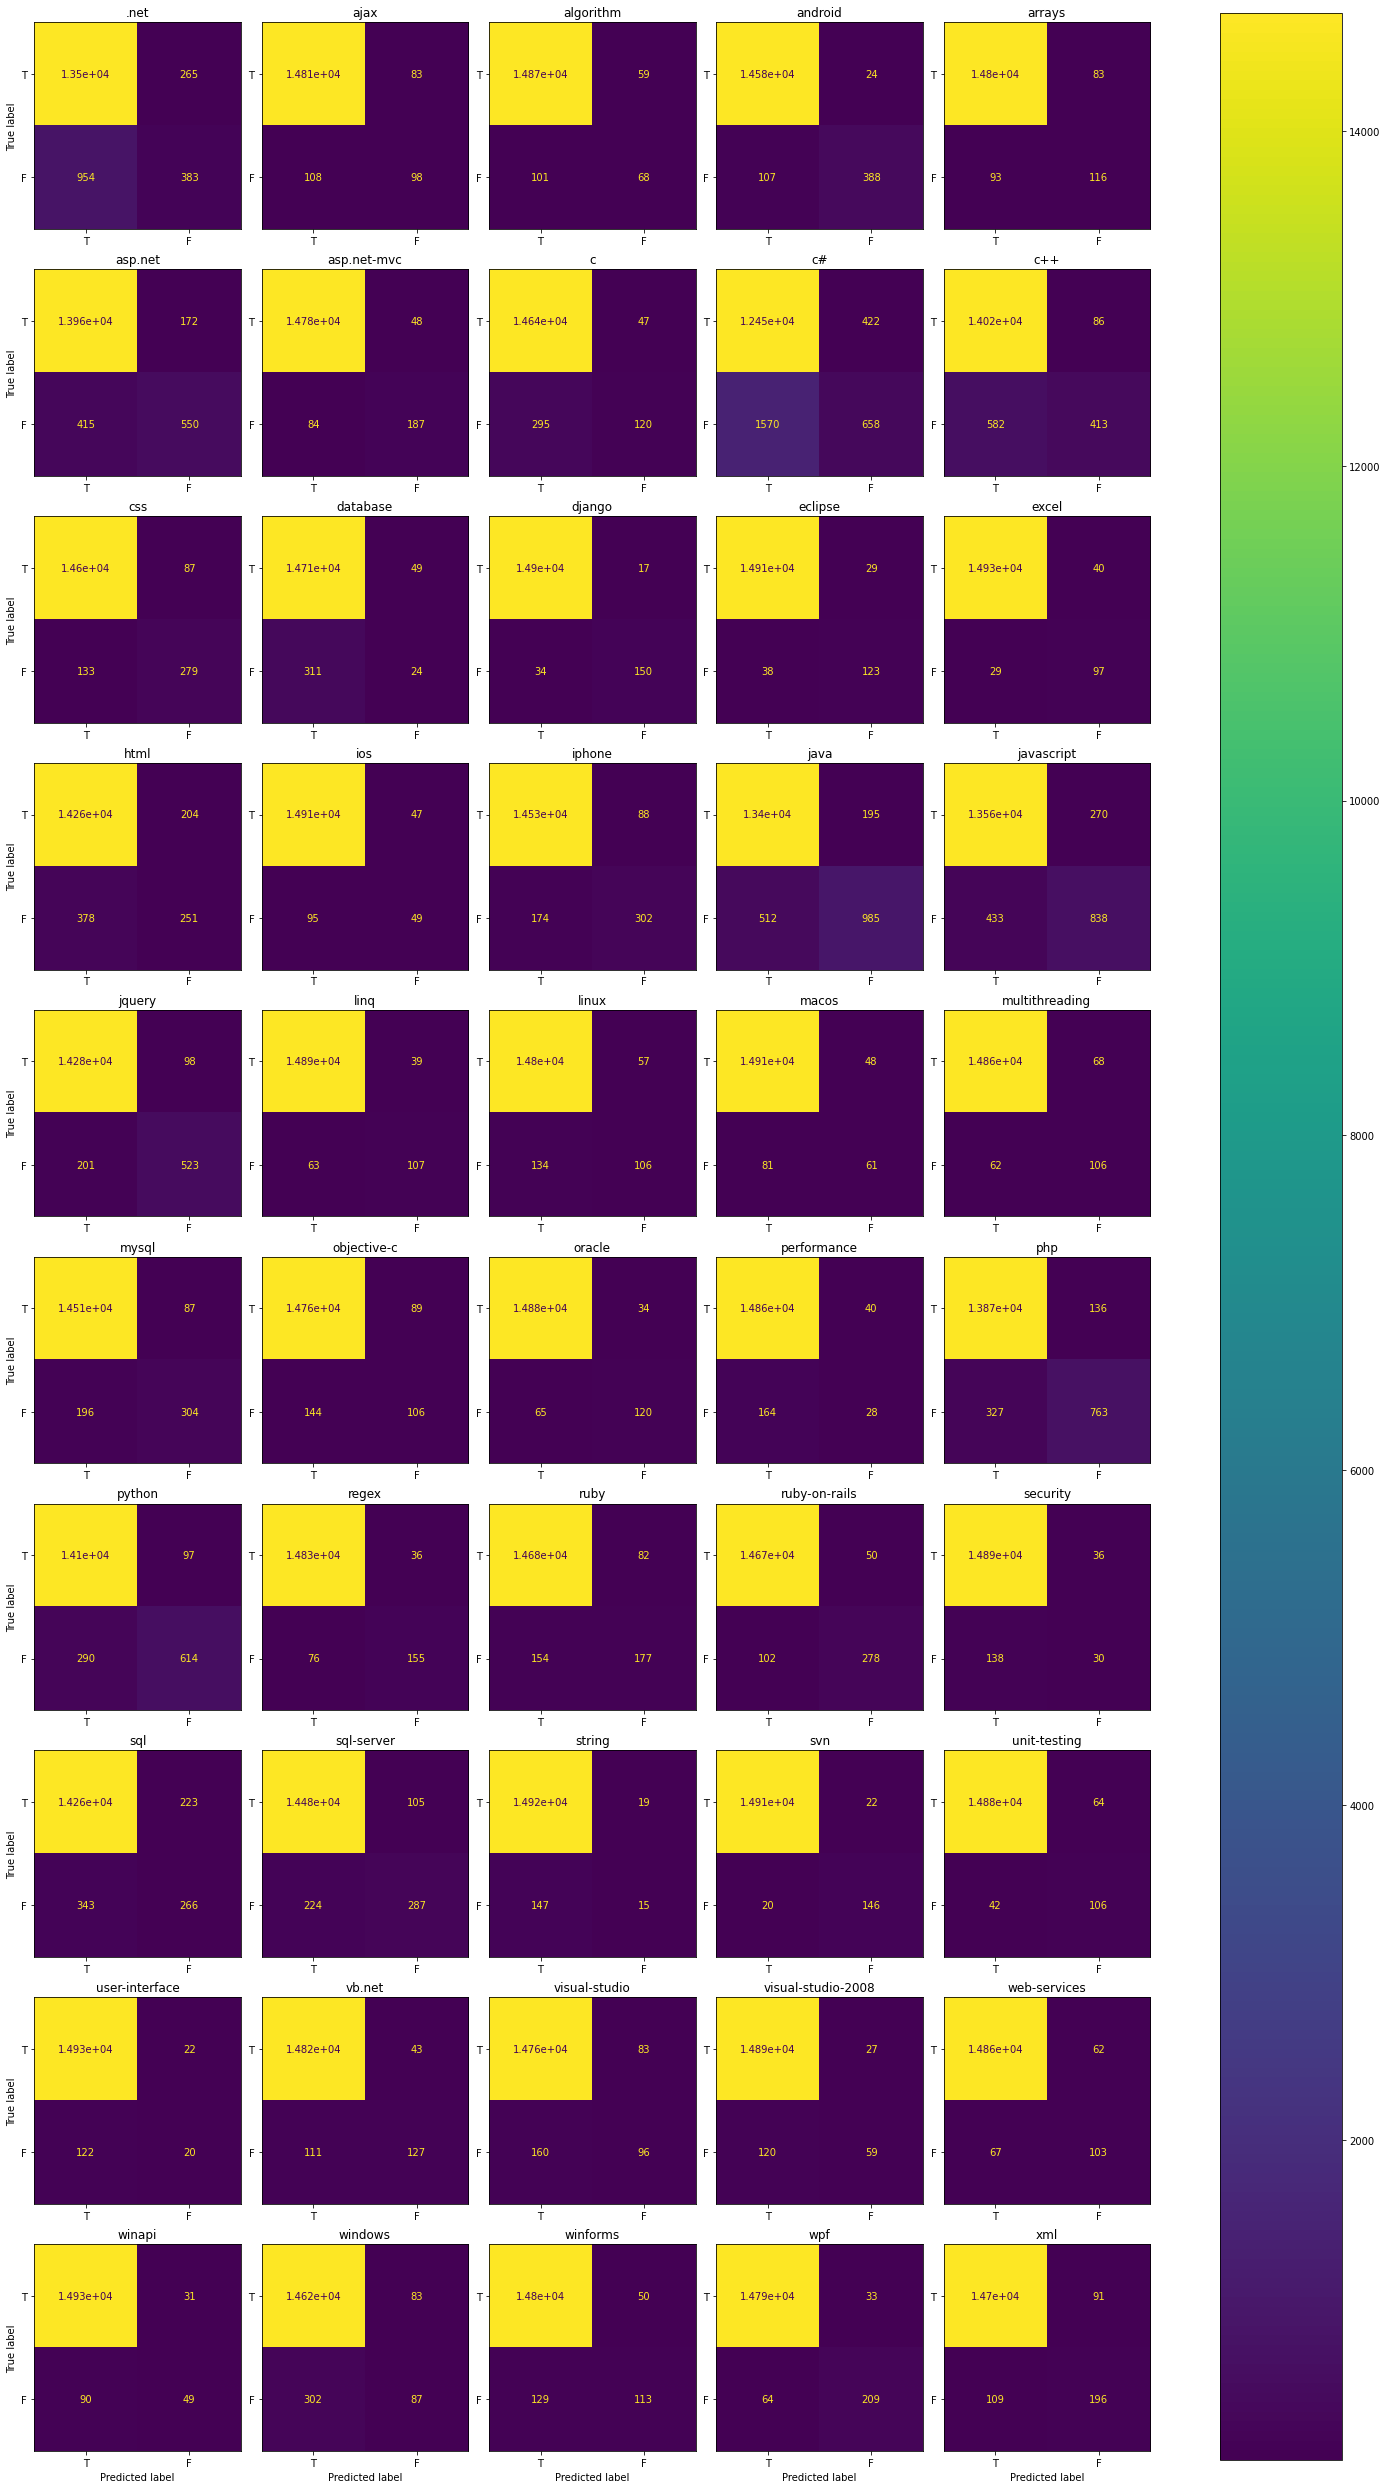

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f, axes = plt.subplots(10, 5, figsize=(25, 45))
axes = axes.ravel()
for i, topic in enumerate(mlb.classes_):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                   pred[:, i]),
                                  display_labels=["T", "F"])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(topic)
    if i<45:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# Export du meilleur modèle entraîné

In [18]:
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin

class ClassifierWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return self.estimator.predict(X)
    
class InverseMLB(BaseEstimator, ClusterMixin):
    def __init__(self, mlb):
        self.mlb = mlb
        
    def fit(self, X, y = None):
        return self
    
    def predict(self, X):
        return self.mlb.inverse_transform(X)

In [26]:
from sklearn.preprocessing import FunctionTransformer
pip = Pipeline([
    ('predict', ClassifierWrapper(grid_search.best_estimator_)),
    ('get-labels', InverseMLB(mlb))
])
pip.fit(X_train, y_train)
pip.predict(['Test'])

[('unit-testing',)]

Test convaincant, on peut exporter !

In [25]:
import cloudpickle
import os

with open('app/backend/pipeline.pkl', 'wb') as f:
    cloudpickle.dump(pip, f)